<a href="https://colab.research.google.com/github/cgrundman/ZTM-TensorFlow-Developer/blob/main/04_transfer_learning_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patters for our own problem.

There are two main benefits:
1.   Can leverage an existing neural network architecture proven to work on problems similar to our own.
2.   Can leverage a working neural network architecture which has already learned patters on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using a GPU?
!nvidia-smi

Sat Jun 22 09:43:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-06-22 09:43:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.207, 142.251.18.207, 142.250.153.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  38.1MB/s    in 4.8s    

2024-06-22 09:43:35 (33.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory an list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

## Creating data loader (preparing the data)

We'll use the ``ImageDataGenerator`` class to load in our images in batches.

In [4]:
# Set data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32


train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print ("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print ("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbcks:

* Tracking experiements with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

The TensorFlow Hub page has been moved to kaggle, so we will look at the following URLs for the models that we will compare:

* "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"
* "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [6]:
# Let's compare the following two models
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"

efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [11]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a Kaggle URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlowHub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to the number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as the feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # Freeze the already earned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [21]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [22]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [23]:
# Compile our ResNet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [24]:
# Let's fit our ResNet model to the data (10 percent of the 10 classes)

resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")
                                  ])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240622-105114
Epoch 1/5
24/24 [==============================] - 17s 567ms/step - loss: 1.9579 - accuracy: 0.3267 - val_loss: 1.2291 - val_accuracy: 0.6156
Epoch 2/5
24/24 [==============================] - 11s 471ms/step - loss: 0.9059 - accuracy: 0.7400 - val_loss: 0.8723 - val_accuracy: 0.7244
Epoch 3/5
24/24 [==============================] - 14s 617ms/step - loss: 0.6172 - accuracy: 0.8293 - val_loss: 0.7689 - val_accuracy: 0.7464
Epoch 4/5
24/24 [==============================] - 13s 544ms/step - loss: 0.4663 - accuracy: 0.8813 - val_loss: 0.7345 - val_accuracy: 0.7592
Epoch 5/5
24/24 [==============================] - 12s 527ms/step - loss: 0.3761 - accuracy: 0.9160 - val_loss: 0.6883 - val_accuracy: 0.7744


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [25]:
import matplotlib.pyplot as plt

# Let's create a function to plot our loss curves
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation loss curves

  Args:
    history: TensorFlow History object

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot Accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

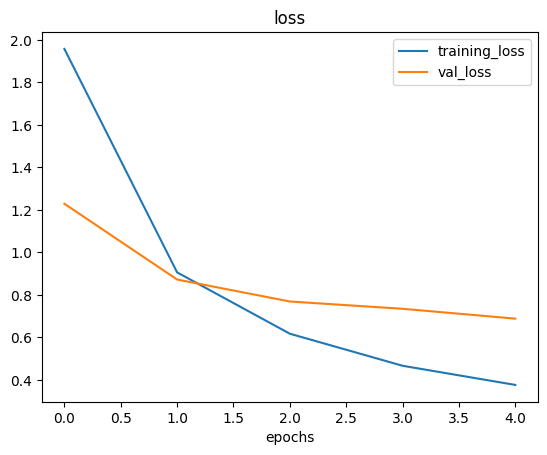

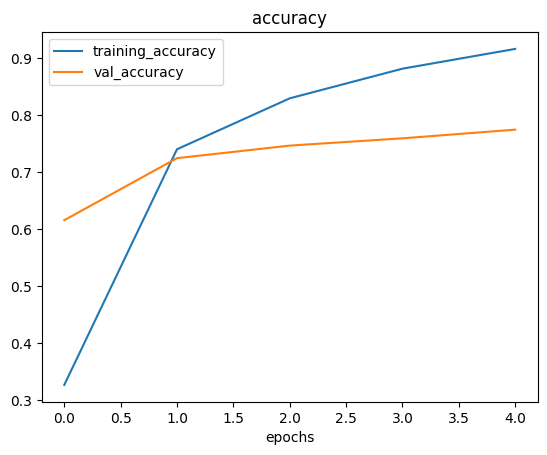

In [26]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 Tensorflow Hub Feature Extraction model

In [27]:
# Create EfficientNet model
efficientnet_model = create_model(efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

In [28]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [29]:
# Compile our EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [30]:
# Let's fit our EfficientNet model to the data (10 percent of the 10 classes)
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                    experiment_name="efficientnetb0")
                                              ])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20240622-105810
Epoch 1/5
24/24 [==============================] - 24s 560ms/step - loss: 1.8260 - accuracy: 0.4427 - val_loss: 1.2877 - val_accuracy: 0.7272
Epoch 2/5
24/24 [==============================] - 13s 538ms/step - loss: 1.0596 - accuracy: 0.7520 - val_loss: 0.8663 - val_accuracy: 0.8156
Epoch 3/5
24/24 [==============================] - 10s 431ms/step - loss: 0.7515 - accuracy: 0.8427 - val_loss: 0.7006 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 10s 435ms/step - loss: 0.6038 - accuracy: 0.8640 - val_loss: 0.6131 - val_accuracy: 0.8496
Epoch 5/5
24/24 [==============================] - 10s 409ms/step - loss: 0.5089 - accuracy: 0.8893 - val_loss: 0.5601 - val_accuracy: 0.8560


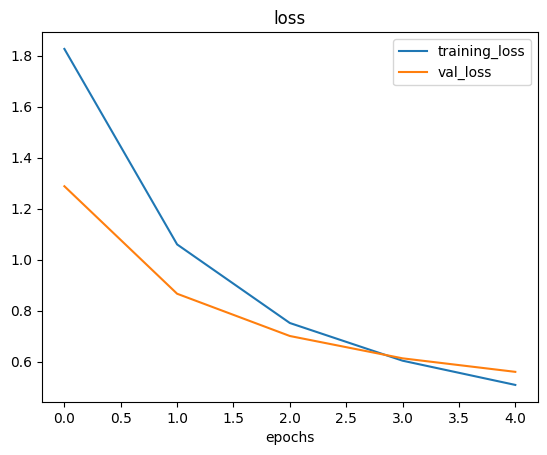

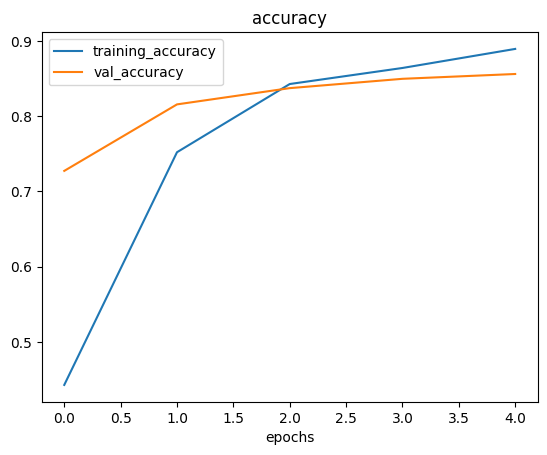

In [31]:
plot_loss_curves(efficientnet_history)